# YOLOv5 Retail Item Detection Notebook

#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
# !git clone https://github.com/jkassis/Retail-Store-Item-Detection-using-YOLOv5
!mv Retail-Store-Item-Detection-using-YOLOv5 yolov5
!pip install -r yolov5/requirements.txt  # install dependencies
!pip install wandb
%cd yolov5

import torch
from IPython.display import Image, clear_output  # to display images
# from utils.google_utils import gdrive_download  # to download models/datasets
from pydrive.drive import GoogleDrive

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Cloning into 'yolov5'...
remote: Enumerating objects: 9884, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 9884 (delta 43), reused 30 (delta 11), pack-reused 9801
Receiving objects: 100% (9884/9884), 10.32 MiB | 26.76 MiB/s, done.
Resolving deltas: 100% (6835/6835), done.
mv: cannot stat 'Retail-Store-Item-Detection-using-YOLOv5': No such file or directory
     |████████████████████████████████| 596 kB 5.1 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.7 MB 5.0 MB/s 
     |████████████████████████████████| 139 kB 55.6 MB/s 
     |████████████████████████████████| 180 kB 69.6 MB/s 
     |████████████████████████████████| 97 kB 8.0 MB/s 


# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


# Download Data

#### We first download the augmented and annotated image data from Roboflow website. Dont forget to enter the data download key link below which has unique key restricted for each user

In [ ]:
# Export code snippet and paste here
%cd /content
robo_flow_data_download_key = "ENTER YOUR DATA DOWNLOAD LINK HERE IN QUOTES"
# !curl -L robo_flow_data_download_key > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
!curl -L "https://app.roboflow.ai/ds/dNpgZfRlr4?key=cteun9wN2k" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    68  100    68    0     0    121      0 --:--:-- --:--:-- --:--:--   121
100   896  100   896    0     0    648      0  0:00:01  0:00:01 --:--:--  1597
100 53.8M  100 53.8M    0     0  28.7M      0  0:00:01  0:00:01 --:--:--  282M
Archive:  roboflow.zip
replace test/images/train_752_jpg.rf.0e684141335f0c59d001064f8afd9e86.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: test/images/train_752_jpg.rf.0e684141335f0c59d001064f8afd9e86.jpg  
replace test/images/train_342_jpg.rf.0921748112ab93f5ceebe90b6ad00f71.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: test/images/train_342_jpg.rf.0921748112ab93f5ceebe90b6ad00f71.jpg  
 extracting: test/images/train_736_jpg.rf.0fe424bb53c9d26d89da0fb133d338be.jpg  
 extracting: test/images/train_232_jpg.rf.1f891713a9f440e14ad9c347bc5aec62.jpg  
 extracting: test/i

In [ ]:
%mkdir -p /content/gdrive/My\ Drive/retail-test-data
%cp -r /content/train /content/gdrive/My\ Drive/retail-test-data
%cp -r /content/test /content/gdrive/My\ Drive/retail-test-data
%cp -r /content/valid /content/gdrive/My\ Drive/retail-test-data

#### We can see in this cell, that class to be predicted is 1 i.e. retail object, as defined in the .yaml file

In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['object']

# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.


In [ ]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
%cd /content/
##write custom model .yaml
#you can configure this based on other YOLOv5 models in the models directory
with open('yolov5/models/custom_yolov5s.yaml', 'w') as f:
  # parameters
  f.write('nc: ' + num_classes + '\n')
  #f.write('nc: ' + str(len(class_labels)) + '\n')
  f.write('depth_multiple: 0.33'  + '\n') # model depth multiple
  f.write('width_multiple: 0.50'  + '\n')  # layer channel multiple
  f.write('\n')
  f.write('anchors:' + '\n')
  f.write('  - [10,13, 16,30, 33,23] ' + '\n')
  f.write('  - [30,61, 62,45, 59,119]' + '\n')
  f.write('  - [116,90, 156,198, 373,326] ' + '\n')
  f.write('\n')


  f.write('# YOLOv5 v6.0 backbone' + '\n')
  f.write('backbone:' + '\n')
  f.write('  # [from, number, module, args]' + '\n')
  f.write('  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2' + '\n')
  f.write('   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4' + '\n')
  f.write('   [-1, 3, C3, [128]],' + '\n')
  f.write('   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8' + '\n')
  f.write('   [-1, 6, C3, [256]],' + '\n')
  f.write('   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16' + '\n')
  f.write('   [-1, 9, C3, [512]],' + '\n')
  f.write('   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32' + '\n')
  f.write('   [-1, 3, C3, [1024]],' + '\n')
  f.write('   [-1, 1, SPPF, [1024, 5]],  # 9' + '\n')
  f.write('  ]' + '\n')
  f.write('' + '\n')
  f.write('# YOLOv5 v6.0 head' + '\n')
  f.write('head:' + '\n')
  f.write('  [[-1, 1, Conv, [512, 1, 1]],' + '\n')
  f.write('   [-1, 1, nn.Upsample, [None, 2, 'nearest']],' + '\n')
  f.write('   [[-1, 6], 1, Concat, [1]],  # cat backbone P4' + '\n')
  f.write('   [-1, 3, C3, [512, False]],  # 13' + '\n')
  f.write('' + '\n')
  f.write('   [-1, 1, Conv, [256, 1, 1]],' + '\n')
  f.write('   [-1, 1, nn.Upsample, [None, 2, 'nearest']],' + '\n')
  f.write('   [[-1, 4], 1, Concat, [1]],  # cat backbone P3' + '\n')
  f.write('   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)' + '\n')
  f.write('' + '\n')
  f.write('   [-1, 1, Conv, [256, 3, 2]],' + '\n')
  f.write('   [[-1, 14], 1, Concat, [1]],  # cat head P4' + '\n')
  f.write('   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)' + '\n')
  f.write('' + '\n')
  f.write('   [-1, 1, Conv, [512, 3, 2]],' + '\n')
  f.write('   [[-1, 10], 1, Concat, [1]],  # cat head P5' + '\n')
  f.write('   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)' + '\n')
  f.write('' + '\n')
  f.write('   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)' + '\n')
  f.write(']' + '\n')
)

print('custom model config written!')

/content
custom model config written!


# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size Use the largest --batch-size your GPU allows (batch sizes shown for 16 GB devices)
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training


During training you will see live updates at https://wandb.ai, and you can create Detailed Reports of your results using the W&B Reports tool.

In [ ]:
# train yolov5s on custom data for 300 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 32 --epochs 300 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results --nosave --cache

/content/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=../data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=300, batch_size=32, imgsz=416, rect=False, resume=False, nosave=True, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-82-g30bc089 torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7,

#### We save our yolov5 trained weights as in .pt file in Google Drive

In [ ]:
%mkdir -p /content/yolov5/weights
%cp /content/yolov5/runs/train/yolov5s_results2/weights/last.pt /content/yolov5/weights/last_yolov5s_results/last_yolov5s_results.pt
%cp /content/yolov5/weights/last_yolov5s_results/* /content/gdrive/My\ Drive/last_yolov5s_results

# Evaluate Custom YOLOv5 Detector Performance

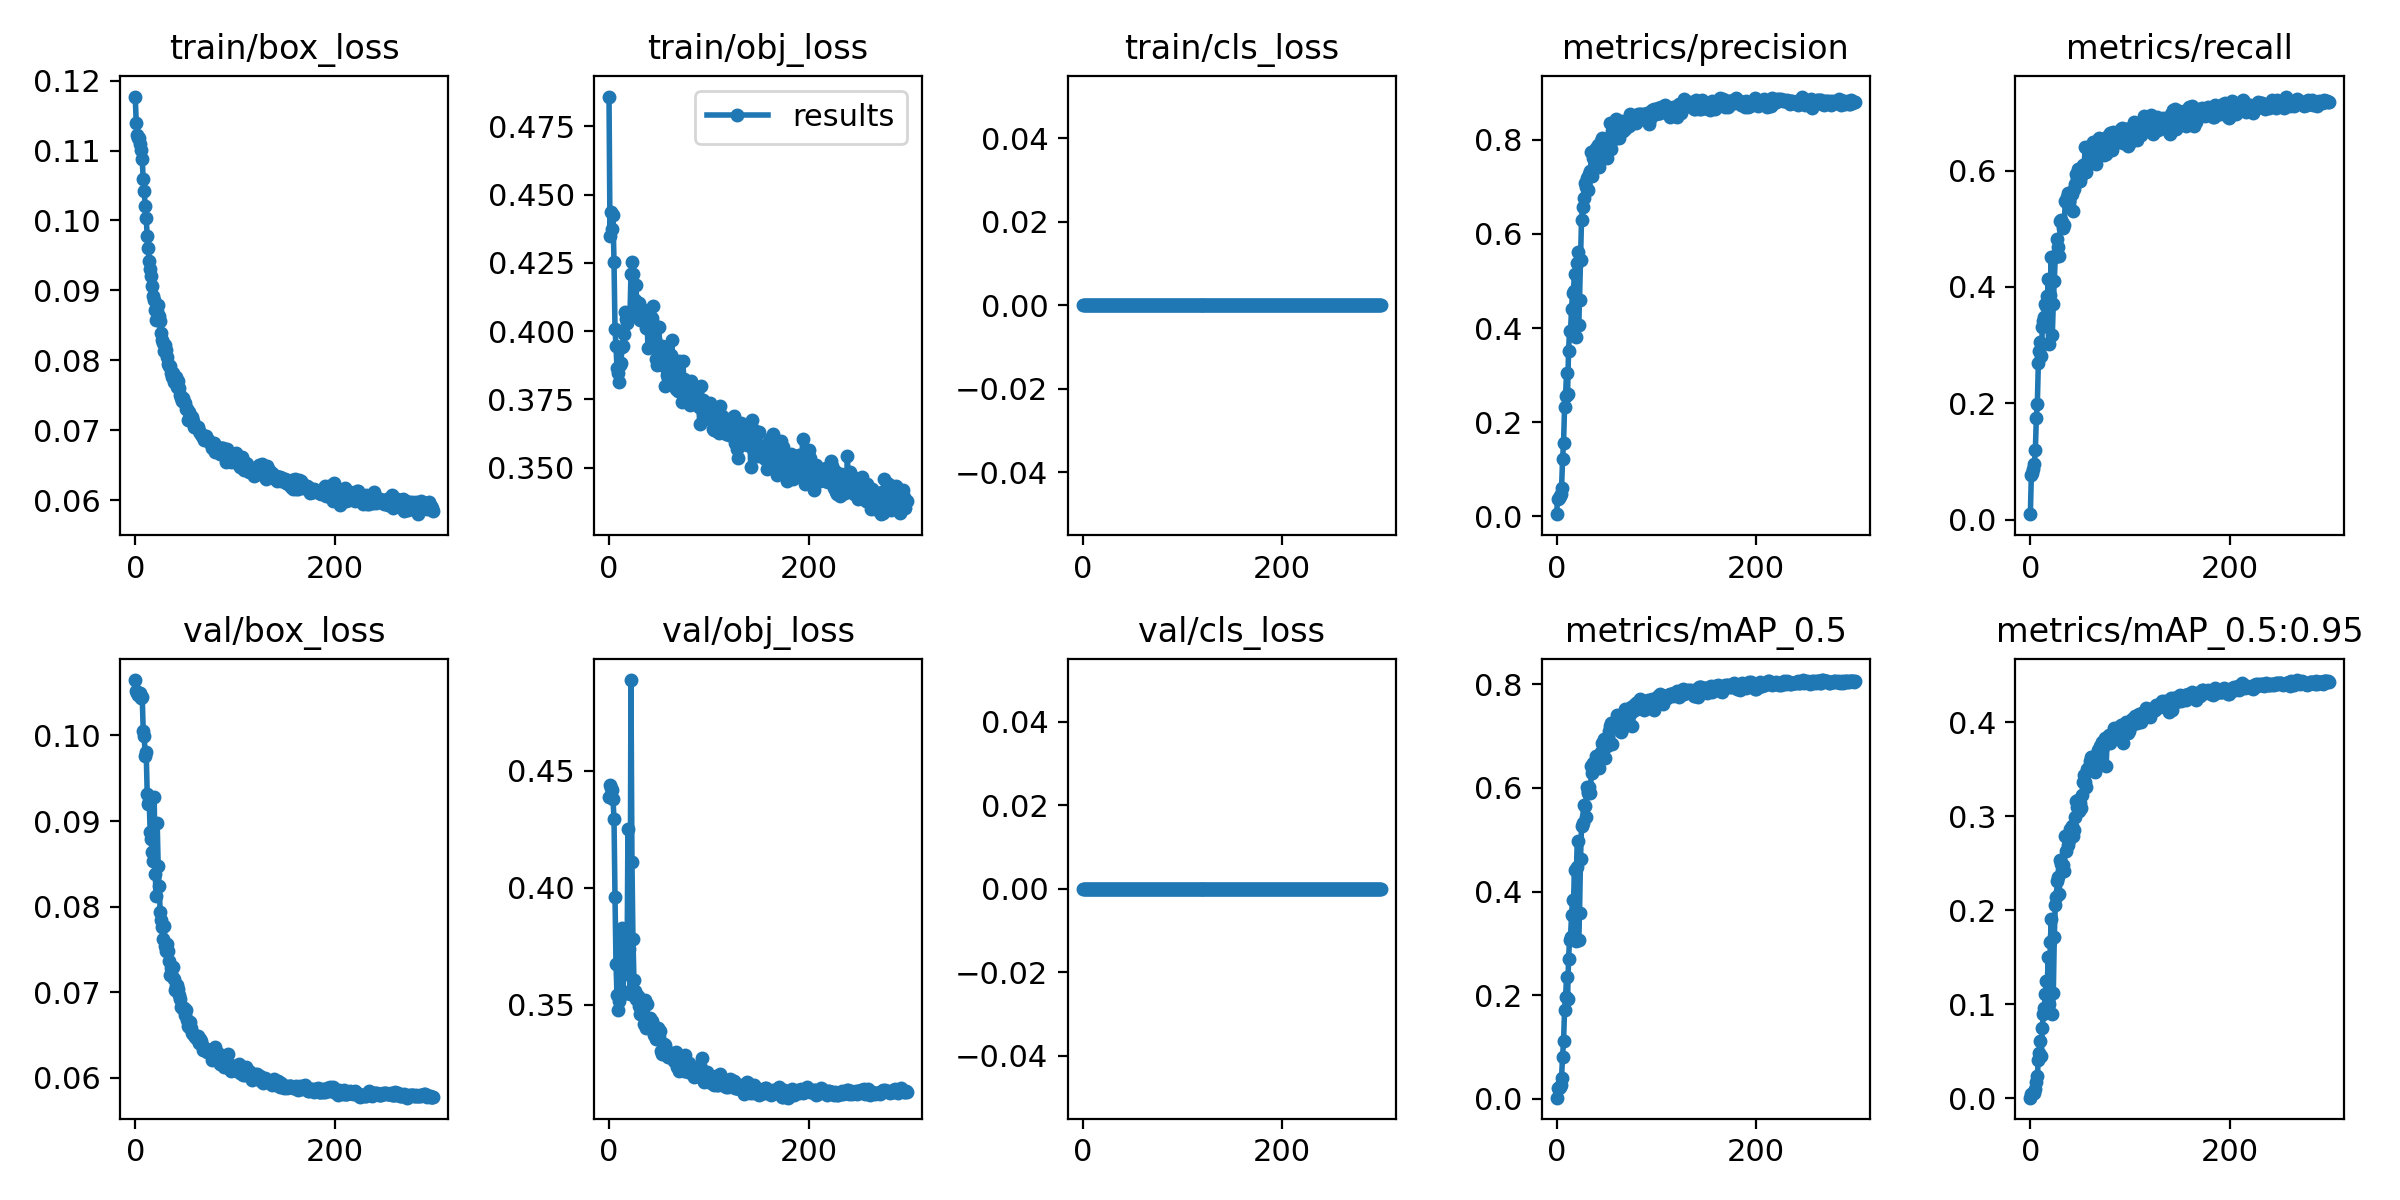

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results
plot_results('/content/yolov5/runs/train/yolov5s_results2/results.csv')  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results2/results.png', width=1000)  # view results.png

### This is the training set image batch with known annotations

GROUND TRUTH AUGMENTED TRAINING DATA:


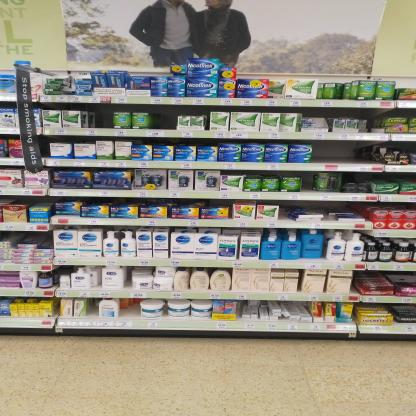

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/train/images/train_102_jpg.rf.5e315c521b97bd064bb9de1c2556acbd.jpg', width=900)

## Predictions

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
# trained weights are saved by default in our weights folder in Colab Pro
%ls weights/

last_yolov5s_results.pt


In [ ]:

%cd /content/yolov5/
!python detect.py --weights weights/last_yolov5s_results/last_yolov5s_results.pt --img 416 --conf 0.4 --source ../test/images


/content/yolov5
detect: weights=['weights/last_yolov5s_results.pt'], source=../test/images, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-82-g30bc089 torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/99 /content/test/images/train_0_jpg.rf.a5e68ac6ddfac17e743e759807f8f5b4.jpg: 416x416 122 objects, Done. (0.006s)
image 2/99 /content/test/images/train_101_jpg.rf.4a9cfcb12de7417dfa1fe885c65bf93e.jpg: 416x416 109 objects, Done. (0.007s)
image 3/99 /content/test/images/train_107_jpg.rf.3fc2fefd30e32f658ce0c34eb6a56e62.jpg: 416x416 144 objects, Done. (0.006s)
image 4/99

### Bounding boxes predicted by our trained YOLOv5 model on test set images

In [ ]:
#display inference on ALL test images
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/inference/output/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

[link text](https://)# Export Trained Weights for Future Inference


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Save the Model

#### Copy the results to Google Drive

In [ ]:
%cp -r /content/yolov5/weights/last_yolov5s_results/* /content/gdrive/My\ Drive/last_yolov5s_results

# Retrieve the Model

In [ ]:
%mkdir -p /content/yolov5/weights/last_yolov5s_results
%cp -r /content/gdrive/My\ Drive/last_yolov5s_results/* /content/yolov5/weights/last_yolov5s_results

# Install Converter Requirements

In [ ]:
!pip install onnx>=1.7.0 # for ONNX export
!pip install onnx-simplifier
!pip install coremltools==4.0 # for CoreML export
!pip install tensorflow-addons
!pip install onnx-tf
!pip install tensorflow==2.6.0

     |████████████████████████████████| 1.1 MB 4.3 MB/s 
     |████████████████████████████████| 222 kB 4.2 MB/s 
     |████████████████████████████████| 458.3 MB 10 kB/s 
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30692 sha256=932beab59cbc7929d47aec5e039d85a27bf85a22a56ca7ea9b334ca5f16758e9
  Stored in directory: /root/.cache/pip/wheels/98/91/04/971b4c587cf47ae952b108949b46926f426c02832d120a082a
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68715 sha256=7578426577c4613c9d35ad4b7a1254e71728b830b6152c13c5f62bf187ef56b2
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built clang wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.1

# Export

In [ ]:
%cd /content/yolov5
%rm -r /content/yolov5/weights/last_yolov5s_results/*.onnx
!echo 'Convert to ONNX'
!export PYTHONPATH="$PWD" && python export.py --weights /content/yolov5/weights/last_yolov5s_results/last_yolov5s_results.pt --include onnx --img 640 --batch 1 # export at 640x640 with batch size 1


/content/yolov5
rm: cannot remove '/content/yolov5/weights/last_yolov5s_results/*.onnx': No such file or directory
Convert to ONNX
export: data=data/coco128.yaml, weights=/content/yolov5/weights/last_yolov5s_results/last_yolov5s_results.pt, imgsz=[640], batch_size=1, device=cpu, half=False, inplace=False, train=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=13, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v6.0-84-gdef7a0f torch 1.9.0+cu111 CPU

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from /content/yolov5/weights/last_yolov5s_results/last_yolov5s_results.pt (14.3 MB)

ONNX: starting export with onnx 1.10.2...
/content/yolov5/models/yolo.py:58: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This m

In [ ]:
%cd /content/yolov5
%rm -r /content/yolov5/weights/last_yolov5s_results/*_web_model
!echo 'Convert to TFJS'
!export PYTHONPATH="$PWD" && python export.py --weights /content/yolov5/weights/last_yolov5s_results/last_yolov5s_results.pt --include tfjs --img 640 --batch 1 # export at 640x640 with batch size 1


/content/yolov5
rm: cannot remove '/content/yolov5/weights/last_yolov5s_results/*_web_model': No such file or directory
Convert to TFJS
export: data=data/coco128.yaml, weights=/content/yolov5/weights/last_yolov5s_results/last_yolov5s_results.pt, imgsz=[640], batch_size=1, device=cpu, half=False, inplace=False, train=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=13, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['tfjs']
YOLOv5 🚀 v6.0-84-gdef7a0f torch 1.9.0+cu111 CPU

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from /content/yolov5/weights/last_yolov5s_results/last_yolov5s_results.pt (14.3 MB)
2021-11-11 19:28:47.068320: E tensorflow/core/lib/monitoring/collection_registry.cc:77] Cannot register 2 metrics with the same name: /tensorflow/api/keras/optimizers

TensorFlow saved_model: export failure: Another metric with the same name already exists.

TensorFlow GraphDef: 

In [ ]:
%cd /content/yolov5
%rm -r /content/yolov5/weights/last_yolov5s_results/*.tflite
!echo 'Convert to TFLITE'
!export PYTHONPATH="$PWD" && python export.py --weights /content/yolov5/weights/last_yolov5s_results/last_yolov5s_results.pt --include tflite --img 640 --batch 1 # export at 640x640 with batch size 1


/content/yolov5
Convert to TFLITE
export: data=data/coco128.yaml, weights=/content/yolov5/weights/last_yolov5s_results/last_yolov5s_results.pt, imgsz=[640], batch_size=1, device=cpu, half=False, inplace=False, train=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=13, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['tflite']
YOLOv5 🚀 v6.0-84-gdef7a0f torch 1.9.0+cu111 CPU

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from /content/yolov5/weights/last_yolov5s_results/last_yolov5s_results.pt (14.3 MB)
2021-11-11 19:29:14.922971: E tensorflow/core/lib/monitoring/collection_registry.cc:77] Cannot register 2 metrics with the same name: /tensorflow/api/keras/optimizers

TensorFlow saved_model: export failure: Another metric with the same name already exists.
2021-11-11 19:29:14.927140: E tensorflow/core/lib/monitoring/collection_registry.cc:77] Cannot register 2 metrics with the

# Copy Models Out to Google Drive

In [ ]:
%cp -r /content/yolov5/weights/last_yolov5s_results/* /content/gdrive/My\ Drive/last_yolov5s_results